In [1]:
import math
import pandas as pd
import mip
import os

smallTimeRange = range(10, 35) #days crickets stay in small condos
totTimeRange = range(51, 64) #ages at which crickets get harvested

totRep=0
for smallTime in smallTimeRange:
    for bigTime in range(min(totTimeRange) - smallTime, max(totTimeRange) - smallTime + 2):
        totRep+=1

In [2]:
#CLASSIC WITHOUT SIZE PROBLEM

is27=True #decide if we're studying crickets reared at 27°C or 29°C

if is27:
    nameFile='results27.csv'
    if os.path.exists(nameFile):
        os.remove(nameFile)
else:
    nameFile='results29.csv'
    if os.path.exists(nameFile):
        os.remove(nameFile)

rep=0 #used to keep track of progress
fixedSalary=500 #worker's fixed pay

totRep=0

for smallTime in smallTimeRange: #cycle on all stays in small condos
    for bigTime in range(min(totTimeRange) - smallTime, max(totTimeRange) - smallTime + 2): #cycle on all stays in big condos
        totRep+=1 #find how many optimizations will be needed

for smallTime in smallTimeRange: #cycle on all stays in small condos
    for bigTime in range(min(totTimeRange) - smallTime, max(totTimeRange) - smallTime + 2): #cycle on all stays in big condos
        if rep%5==0:
            print('Rep: ',rep,'/',totRep) #progress check
        rep+=1
        
        #PARAMETERS DEFINITION
        
        nDays=1000 #timeframe studied
        nCondos=1000 #condos in the farm
        totSpace=1000 #space available
        bigSize=2 #space needed for each big condo
        smallSize=0.25 #space needed for each small condo
        D=range(nDays) #days

        #work needed for various tasks
        transfWork=2 #to move pops
        newPopWork=3 #to bring pops from nursery
        harvestWork=7 #to harvest a pop

        #retrieve parameters from previous data
        gcd= math.gcd(smallTime, bigTime) #greatest common denominator between stays
        nCondosPerGroup= (bigTime + smallTime) / gcd #number of condos in each closed group
        period= round(smallTime*(bigTime+smallTime)/gcd) #time needed to complete a full cycle in each group of condos
        nGroups=math.floor(nCondos / nCondosPerGroup) #how many groups there are

        nSmallCondos=round(smallTime/(smallTime+bigTime)*nCondos) #tot number of small condos in the farm
        nBigCondos=nCondos-nSmallCondos #tot number of big condos in the farm
        
        #depending on what we're studying, use different weight data
        if is27:
            crickets_weight_age_mg =[0.66, 0.84, 1.01, 1.19, 1.37, 1.55, 1.72, 1.9, 2.29, 2.67, 3.06, 3.44, 3.83, 4.21, 4.6, 5.49, 6.37, 7.26, 8.14, 9.03, 9.91, 10.8, 12.79, 14.77, 16.76, 18.74, 20.73, 22.71, 24.7, 28.73, 32.76, 36.79, 40.81, 44.84, 48.87, 52.9, 60.37, 67.84, 75.31, 82.79, 90.26, 97.73, 105.2, 116.27, 127.34, 138.41, 149.49, 160.56, 171.63, 182.7, 194.94, 207.19, 219.43, 231.67, 243.91, 256.16, 268.4, 275.94, 283.49, 291.03, 298.57, 306.11, 313.66, 321.2, 326.07, 330.94, 335.81, 340.69, 345.56, 350.43, 355.3, 355.3, 355.3, 355.3, 355.3, 355.3, 355.3] #27
        else:
            crickets_weight_age_mg = [0.68, 0.9, 1.11, 1.33, 1.55, 1.77, 1.98, 2.2, 2.97, 3.74, 4.51, 5.29, 6.06, 6.83, 7.6, 9.76, 11.91, 14.07, 16.23, 18.39, 20.54, 22.7, 27.34, 31.99, 36.63, 41.27, 45.91, 50.56, 55.2, 62.26, 69.31, 76.37, 83.43, 90.49, 97.54, 104.6, 113.61, 122.63, 131.64, 140.66, 149.67, 158.69, 167.7, 175.99, 184.27, 192.56, 200.84, 209.13, 217.41, 225.7, 228.99, 232.27, 235.56, 238.84, 242.13, 245.41, 248.7, 252.06, 255.41, 258.77, 262.13, 265.49, 268.84, 272.2, 272.2, 272.2, 272.2, 272.2, 272.2, 272.2] #29
        
        
        kg_to_mg_ratio=1000000
        cricketsCondo=50000 #how many crickets there are in each condo
        survPerc=0.6 #percentage of crickets that arrive at harvesting age
        dryMatterPerc=0.25 #how much of the live weight will turn to flour
        price=50 #profits from selling a kg of cricket flour
        unitOfWorkCost=1 #how much each unit of work costs
        weekendCost=0.25 #bonus pay if a unit of work is done during the weekend

        maxWorkWorker=25 #limit max workers

        #model instantiation
        model=mip.Model()


        #VARIABLES DEFINITION

        nTransf_d={d:model.add_var(var_type=mip.INTEGER,name="Num of transferred pops on day "+str(d)) for d in D}
        nNewPop_d={d:model.add_var(var_type=mip.INTEGER,name="Num of new pops on day "+str(d)) for d in D}
        nHarvests_d={d:model.add_var(var_type=mip.INTEGER,name="Num of harvested pops on day "+str(d)) for d in D}
        workNeeded_d={d:model.add_var(var_type=mip.INTEGER,name="Qty of work on day "+str(d)) for d in D}
        harvestedQtyKG_d={d:model.add_var(name="Kg harvested on day " + str(d)) for d in D}
        profit=model.add_var(name="Profit made in the time stamp")
        workCost_d={d:model.add_var(var_type=mip.CONTINUOUS, name='Cost of work on day ' + str(d)) for d in D}
        nWorkers=model.add_var(var_type=mip.INTEGER,name='Num workers')

        
        #Can't harvest more condos than there are in the whole farm
        for d in D:
            model.add_constr(nHarvests_d[d]<=nCondos)

        #When pops get harvested, an equal amount of new pops gets transferred from the nursery to small condos
        for d in D:
            model.add_constr(nNewPop_d[d]==nHarvests_d[d])

        #When small condos move their pop to bigger condos, they receive new pop from nursery
        for d in D[:-smallTime]:
            model.add_constr(nNewPop_d[d]==nTransf_d[d+smallTime])

        #Pop that arrive in big condos get harvested after a fixed time
        for d in D[:-bigTime]:
            model.add_constr(nTransf_d[d]==nHarvests_d[d+bigTime])

        #Correct evaluation of work needed for all tasks
        for d in D:
            model.add_constr(workNeeded_d[d]==nNewPop_d[d]*newPopWork+nTransf_d[d]*transfWork+nHarvests_d[d]*harvestWork)
            
        #Small condos get new pops from nursery at a fixed frequency
        for d in D[:-smallTime]:
            model.add_constr(nNewPop_d[d]==nNewPop_d[d+smallTime])
            
        # start correctly
        model.add_constr(mip.xsum(nNewPop_d[d] for d in D[:smallTime])<=nSmallCondos)
        
        # qty harvested
        for d in D:
            model.add_constr(harvestedQtyKG_d[d] == nHarvests_d[d] * crickets_weight_age_mg[smallTime + bigTime] * cricketsCondo * survPerc * dryMatterPerc / kg_to_mg_ratio)

        #cost of work
        for d in D:
            if d % 7 == 5 or d % 7 == 6: #is weekend
                model.add_constr(workCost_d[d] == workNeeded_d[d]*(1+weekendCost)*unitOfWorkCost+nWorkers*fixedSalary/30)
            else:
                model.add_constr(workCost_d[d] == workNeeded_d[d]*unitOfWorkCost+nWorkers*fixedSalary/30)

        # enough workers
        for d in D:
            model.add_constr(nWorkers*maxWorkWorker>=workNeeded_d[d])

        #Profits= earnings - costs
        model.add_constr(profit == mip.xsum(price * harvestedQtyKG_d[d] for d in D) - mip.xsum(workCost_d[d] for d in D))
        
        #Objective function: maximize profits
        model.objective=mip.maximize(profit)

        model.optimize()

        #Save results to pandas df, for further analysis
        resultsDF=pd.DataFrame(columns=['profit','salesRevenue','workCost','numWorkers','smallDays','bigDays'])
        if os.path.exists(nameFile):
            #os.remove(nameFile)
            resultsDF=pd.read_csv(nameFile)
        else:
            resultsDF=pd.DataFrame(columns=['profit','salesRevenue','workCost','numWorkers','smallDays','bigDays'])
        salesRevenue= sum(price * harvestedQtyKG_d[d].x for d in D)
        workCost= sum(workCost_d[d].x for d in D)
        #print('sales sum: ',salesRevenue,' ,workCost: ',workCost)
        res=salesRevenue-workCost
        #print('result: ',res,' real res: ',profit.x)
        tempDF=pd.DataFrame([{'profit':profit.x,'salesRevenue':salesRevenue,'workCost':workCost,'numWorkers':nWorkers.x,'smallDays':smallTime,'bigDays':bigTime}])
        resultsDF=pd.concat([resultsDF,tempDF],ignore_index=True)
        resultsDF.to_csv(nameFile,index=False)

#Inform the user that all runs have been performed
print("Done")

Rep:  0 / 350
Rep:  5 / 350
Rep:  10 / 350
Rep:  15 / 350
Rep:  20 / 350
Rep:  25 / 350
Rep:  30 / 350
Rep:  35 / 350
Rep:  40 / 350
Rep:  45 / 350
Rep:  50 / 350
Rep:  55 / 350
Rep:  60 / 350
Rep:  65 / 350
Rep:  70 / 350
Rep:  75 / 350
Rep:  80 / 350
Rep:  85 / 350
Rep:  90 / 350
Rep:  95 / 350
Rep:  100 / 350
Rep:  105 / 350
Rep:  110 / 350
Rep:  115 / 350
Rep:  120 / 350
Rep:  125 / 350
Rep:  130 / 350
Rep:  135 / 350
Rep:  140 / 350
Rep:  145 / 350
Rep:  150 / 350
Rep:  155 / 350
Rep:  160 / 350
Rep:  165 / 350
Rep:  170 / 350
Rep:  175 / 350
Rep:  180 / 350
Rep:  185 / 350
Rep:  190 / 350
Rep:  195 / 350
Rep:  200 / 350
Rep:  205 / 350
Rep:  210 / 350
Rep:  215 / 350
Rep:  220 / 350
Rep:  225 / 350
Rep:  230 / 350
Rep:  235 / 350
Rep:  240 / 350
Rep:  245 / 350
Rep:  250 / 350
Rep:  255 / 350
Rep:  260 / 350
Rep:  265 / 350
Rep:  270 / 350
Rep:  275 / 350
Rep:  280 / 350
Rep:  285 / 350
Rep:  290 / 350
Rep:  295 / 350
Rep:  300 / 350
Rep:  305 / 350
Rep:  310 / 350
Rep:  315 / 35

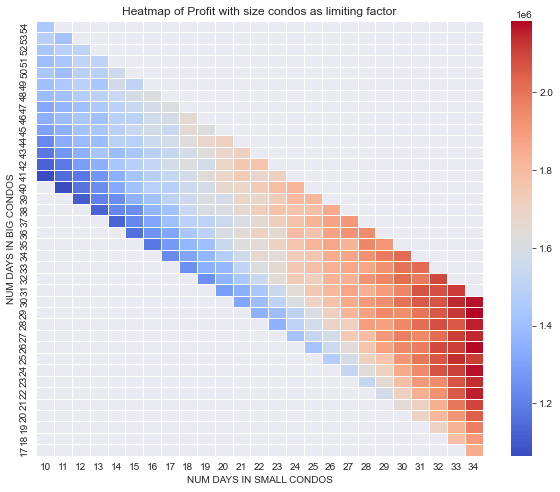

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#open correct csv
if is27:
    df=pd.read_csv('results27WithSize.csv')
else:
    df=pd.read_csv('results29WithSize.csv')

# Create a pivot table for heatmap
heatmap_data = df.pivot('bigDays', 'smallDays', 'profit')[::-1]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, fmt=".2f", linewidths=.5)

# Set labels and title
plt.xlabel('NUM DAYS IN SMALL CONDOS')
plt.ylabel('NUM DAYS IN BIG CONDOS')
plt.title('Heatmap of Profit with size condos as limiting factor')

plt.savefig('heatmap29.png')

# Show the plot
plt.show()

In [4]:
#Display 5 best combinations
dfSortedProfit=df.sort_values('profit', ascending=False).head()
dfSortedProfit=dfSortedProfit[['profit','smallDays','bigDays']]
dfSortedProfit

,profit,smallDays,bigDays
348,2.183757e+06,34,29
345,2.178610e+06,34,26
349,2.169225e+06,34,30
343,2.166408e+06,34,24
347,2.157276e+06,34,28
